In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from varqus.ode import define_vqs_ode, define_schrodinger_ode
from varqus.integrators import euler
from varqus.states import state_from_parameters, state_infidelity

# Variational Quantum Simulator for the 2 qubits quantum Ising model

Following $[$[1](https://doi.org/10.1103/PhysRevLett.107.070601)$]$, we test our variational algorith for the quantum Ising model $[$[2](https://en.wikipedia.org/wiki/Ising_model)$]$. The Hamiltonian of the model is given by:

$$
H = H_{z} + H_{x} = -J \sum_{j=1}^{n_{\mathrm{s}}} \sigma_{j}^{\mathrm{z}} \sigma_{j+1}^{\mathrm{z}} - B\sum_{j=1}^{n_{\mathrm{s}}} \sigma_{j}^{\mathrm{x}}
$$

where $n_s$ is the number of spins, $J$ is the interaction between nearest neighbours spins and $B$ is an external magnetic field. The operators $\sigma^{x}_{j}$ and $\sigma^{z}_{j}$ are the $X$ and $Z$ Pauli operators acting on the $j$ site, and every pair is counted once. For the 2 spins case $n_{s}=2$, and taking the constants $J=B=\frac{1}{2}$, the Hamiltonian becomes:

$$
H = H_{z} + H_{x} = -\frac{1}{2} \left( ZZ\right) -\frac{1}{2} \left(XI + IX \right)
$$

The trial state $|\Psi\rangle$ for the hybrid algorithm is

$$
|\Psi (\lambda_1, \lambda_2) \rangle = R(\lambda_1, \lambda_2) |\Phi(0)\rangle = e^{i \lambda_{1} H_{x}} e^{i \lambda_{2} H_{z}} |\Phi(0)\rangle
$$

where $R(\lambda_1, \lambda_2)$ is a sequence of quantum gates determined by parameters $(\lambda_1, \lambda_2)$ and the initial state $|\Phi(0)\rangle$ is a one-dimensional cluster state given by

$$
|\Phi(0)\rangle = H_{1} H_{2} |00\rangle = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle  \right)
$$

where $H_i$ is the Hadamard gates acting on the $i$-th qubit.

First, we define the proper parameters and operators to construct the Hamiltonian $H$, the trial state $|\Psi\rangle$ and the initial state $|\Phi(0)\rangle$. 

In [2]:
J = 1/2
B = 1/2

# Hamiltonian parameters and operators

hs = [-J, -B, -B]
opsH = ["ZZ", "XI", "IX"]

# Rotations parameters and operators

fs = [[-1j*J], [-1j*B, -1j*B]]
ops = [["ZZ"], ["XI", "IX"]]

# Initial state

ini_state = np.ones(4, dtype=complex)/2

Then, we fix the time step $\delta t$, the number of steps $N_t$ and the initial parameters $\lambda^{0}_{1}, \lambda^{0}_{2}$ for the trial state

In [3]:
# Time discretization and initial parameters for the trial state

params_init = np.array([1.0, 1.0])
dt = 0.01
Nt = 100

Now, we execute our algorithm, first defining the ordinary diferential equation using the variational quantum simulator, and then solving it using a numerical Euler's method, to obtain the parameters in a posterior time $\left\{\lambda_{k}\left(t_{n}\right)\right\}$.

In [4]:
# Define the ode as a function of the parameters

ode = define_vqs_ode(ops, opsH, fs, hs, ini_state, shots=2**13)

# Integrate in time using Euler's method
lambda_k_t = euler(ode, params_init, dt, Nt)

In [5]:
# If you don't want to run the full algorithm, an example is attached on the file "params_2qubits.hdf5".
# Comment the two previous line and uncomment the last two lines

# Save simulated parameters

params_sim = h5py.File("data/params_2qubits.hdf5", "w")
dset = params_sim.create_dataset("params", np.shape(lambda_k_t), data=lambda_k_t)
params_sim.close()

# Load simulated parameters

# params_sim = h5py.File('data/params_2qubits.hdf5', 'r')
# lambda_k_t = params_sim["params"][:]

Text(0.5, 1.0, 'Parameter Evolution using the Variational Quantum Simulator')

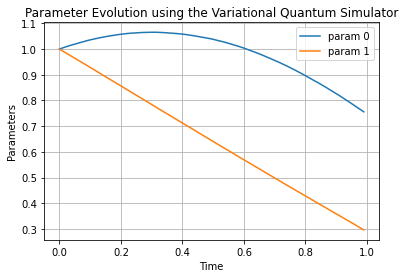

In [6]:
# Plot parameter evolution

plt.plot(dt*np.arange(Nt), lambda_k_t, label = [f"param {i}" for i in range(lambda_k_t.shape[1])])
plt.xlabel("Time")
plt.ylabel("Parameters")
plt.legend(loc="best")
plt.title("Parameter Evolution using the Variational Quantum Simulator")

We want to compare our results to the actual time evolution of the state obtained solving the Schrödinger equation. First, we need to make sure that for the initial parameters, the trial state $|\Psi (\lambda_1^0, \lambda_2^0) \rangle$ is equivalent to the initial state for $t=0$. We will fix then as initial state for the evolution $|\Phi_s (0) \rangle$ such that

$$
|\Phi_s (0) \rangle = e^{i \lambda_1^0 H_{x}} e^{i \lambda_2^0 H_{z}} |\Phi (0) \rangle = |\Psi (\lambda_1^0, \lambda_2^0) \rangle
$$

and the state evolution is then given by

$$
|\Phi_s (t) \rangle = e^{-i H t} |\Phi_s (0) \rangle
$$

In [7]:
initial_state_s = state_from_parameters(params_init, ops, fs, ini_state)

The Schrödinger equation is then solved numerically using the Euler's method

In [8]:
# Solve the schrodinger equation numerically

schrodinger = define_schrodinger_ode(opsH, hs)
numeric_evolution = euler(schrodinger, initial_state_s, dt, Nt)

And finally we get the states from the parameters, and compare the results between $|\Psi (\lambda_1(t), \lambda_2(t)) \rangle$ and $|\Phi_s (t) \rangle$.

Text(0.5, 1.0, 'Infidelity between the obtained state from the VQS and the Schrödinger evolution')

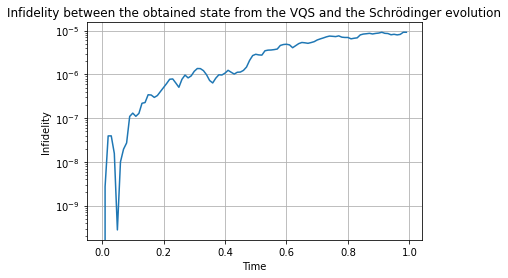

In [9]:
# From params to the state psi(lambda)

psi_lambda_t = [state_from_parameters(lambda_k_t[t], ops, fs, ini_state) for t in range(Nt)]


# Calculate infidelity from the circuit vqs with the schrodinger equation solution using matrix exponentiation

inf_array = [state_infidelity(numeric_evolution[t], psi_lambda_t[t]) for t in range(Nt)]

plt.plot(dt*np.arange(Nt), inf_array)
plt.xlabel("Time")
plt.ylabel("Infidelity")
plt.yscale("log")
plt.title("Infidelity between the obtained state from the VQS and the Schrödinger evolution")

## References

[1] Ying Li and Simon C. Benjamin. Efficient variational quantum simulator incorporating active error minimization. $\textit{Phys. Rev. X}$, 7:021050, Jun 2017. DOI: https://doi.org/10.1103/PhysRevX.7.021050. URL: https://link.aps.org/doi/10.1103/PhysRevX.7.021050.

[2] https://en.wikipedia.org/wiki/Ising_model